In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 2. Install required packages
!pip install efficientnet_pytorch


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.8 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=59c47fea1ae724a1eceb8e3239ca4616c22bc60dd6367d93

In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/FER2013_Project/fer2013.csv'
df = pd.read_csv(csv_path)
df.head()
data = pd.read_csv(csv_path)
print("Dataset shape:", data.shape)
print(data['emotion'].value_counts())


Dataset shape: (35887, 3)
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


In [ ]:
!pip install seaborn

In [ ]:
from sklearn.model_selection import train_test_split
import cv2
import numpy as np

# Convert pixel values to numpy arrays and normalize
pixels = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32').reshape(48, 48) / 255.0)
X = np.stack(pixels.values)
X = np.expand_dims(X, -1)  # Add channel dimension
y = data['emotion'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Custom Dataset
class FERDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = (self.images[idx] * 255).astype(np.uint8)  # convert back to uint8
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transform for EfficientNet
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # convert 1-channel to 3-channel
    transforms.ToTensor()
])

# Loaders
train_loader = DataLoader(FERDataset(X_train, y_train, transform), batch_size=64, shuffle=True)
test_loader = DataLoader(FERDataset(X_test, y_test, transform), batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=7)
model = model.to(device)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 272MB/s]


Loaded pretrained weights for efficientnet-b0


In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(loader)
        epoch_acc = 100 * correct / total
        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")
train_model(model, train_loader, optimizer, epochs=10)


Epoch 1: Loss = 1.2997, Accuracy = 50.74%
Epoch 2: Loss = 0.9522, Accuracy = 64.40%
Epoch 3: Loss = 0.7873, Accuracy = 71.09%
Epoch 4: Loss = 0.6415, Accuracy = 76.75%
Epoch 5: Loss = 0.4981, Accuracy = 82.21%
Epoch 6: Loss = 0.3805, Accuracy = 86.56%
Epoch 7: Loss = 0.2972, Accuracy = 89.76%
Epoch 8: Loss = 0.2340, Accuracy = 92.05%
Epoch 9: Loss = 0.1970, Accuracy = 93.28%
Epoch 10: Loss = 0.1690, Accuracy = 94.19%


In [ ]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
import numpy as np

# Get predictions
def get_predictions(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_prob)

y_true, y_pred, y_prob = get_predictions(model, test_loader)


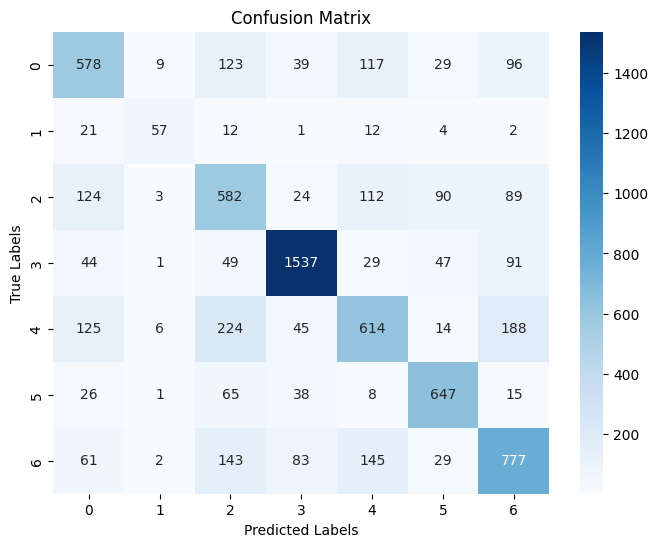

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


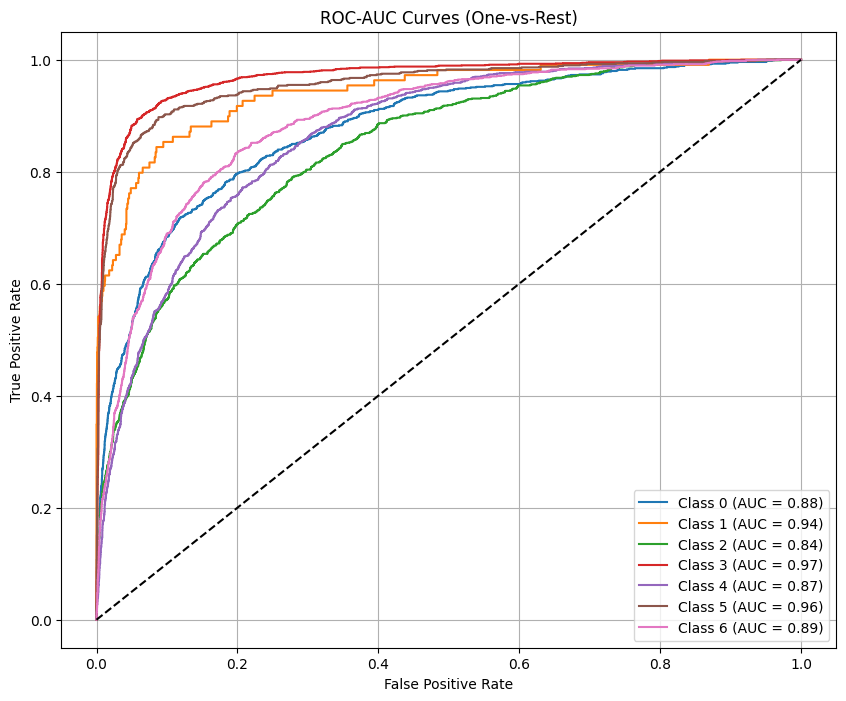

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# One-hot encode true labels
y_true_bin = label_binarize(y_true, classes=np.arange(7))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for all classes
plt.figure(figsize=(10, 8))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-AUC Curves (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Overall metrics
overall_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("📌 Overall Accuracy:", round(overall_accuracy * 100, 2), "%")
print("📌 Precision:", round(precision, 4))
print("📌 Recall:", round(recall, 4))
print("📌 F1 Score:", round(f1, 4))

# Detailed report per class
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, digits=4))


📌 Overall Accuracy: 66.76 %
📌 Precision: 0.6705
📌 Recall: 0.6676
📌 F1 Score: 0.6676

📋 Classification Report:

              precision    recall  f1-score   support

           0     0.5904    0.5832    0.5868       991
           1     0.7215    0.5229    0.6064       109
           2     0.4858    0.5684    0.5239      1024
           3     0.8698    0.8548    0.8623      1798
           4     0.5921    0.5049    0.5451      1216
           5     0.7523    0.8087    0.7795       800
           6     0.6176    0.6266    0.6221      1240

    accuracy                         0.6676      7178
   macro avg     0.6614    0.6385    0.6466      7178
weighted avg     0.6705    0.6676    0.6676      7178

